# 3B: Feature Matching and Autostitching (Notebook)

This notebook implements the main steps for assignment `3B`: Harris corner detection, ANMS, 8x8 descriptor extraction (sampled from 40x40 patches), feature matching (Lowe ratio test), 4-point RANSAC for homography estimation, and a simple stitching pipeline.

Notes: I provide implementations of the required functions and a default example that attempts to load images from the repository. You can change the example paths to run on different image pairs.

In [92]:
# Import dependencies and some display helpers
import os
from typing import List, Tuple
import numpy as np
import cv2
import matplotlib.pyplot as plt

plt.rcParams['figure.dpi'] = 120

def imshow_rgb(img, figsize=(8,6), title=None):
    if img is None:
        print('None image')
        return
    if img.ndim == 2:
        plt.imshow(img, cmap='gray')
    else:
        # OpenCV uses BGR
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    if title: plt.title(title)
    plt.axis('off')
    plt.show()

def draw_keypoints(img, kps, color=(0,255,0), radius=3, alpha=1.0):
    out = img.copy() if img.ndim==3 else cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    for (x,y,score) in kps:
        cv2.circle(out, (int(x),int(y)), radius, color, 1, cv2.LINE_AA)
    return out

In [93]:
# 1) Harris corner detection: call get_harris_corners from harris.py in the repo
from harris import get_harris_corners

def harris_corners(img_gray: np.ndarray, thresh_rel=0.01, edge_discard=20):
    h, coords = get_harris_corners(img_gray, edge_discard=edge_discard)
    # coords: shape (2, N) with rows (ys, xs) per harris.py implementation
    kps = []
    if coords is None or coords.size == 0:
        return [], h
    ys = coords[0]
    xs = coords[1]
    maxv = float(h.max()) if h is not None else 0.0
    th = thresh_rel * maxv
    for i in range(xs.shape[0]):
        x = float(xs[i])
        y = float(ys[i])
        val = float(h[int(y), int(x)])
        if val >= th:
            kps.append((x, y, val))
    # sort by response desc
    kps = sorted(kps, key=lambda x: x[2], reverse=True)
    return kps, h


In [94]:
# 2) ANMS (Adaptive Non-Maximal Suppression)
def anms(kps: List[Tuple[float,float,float]], num_keep=500, robust=0.9):
    # kps: list of (x,y,score) sorted desc by score
    n = len(kps)
    if n == 0:
        return []
    radii = np.full(n, np.inf, dtype=np.float32)
    xs = np.array([p[0] for p in kps])
    ys = np.array([p[1] for p in kps])
    ss = np.array([p[2] for p in kps])
    for i in range(n):
        # find points with significantly larger strength
        stronger = np.where(ss > robust * ss[i])[0]
        if stronger.size == 0:
            radii[i] = np.inf
        else:
            dx = xs[stronger] - xs[i]
            dy = ys[stronger] - ys[i]
            d2 = dx*dx + dy*dy
            radii[i] = np.sqrt(d2.min())
    # keep points with largest radii
    order = np.argsort(-radii)
    selected = []
    for idx in order[:num_keep]:
        selected.append(kps[idx])
    return selected


In [95]:
# 3) Descriptor extraction: sample from 40x40 window, downsample to 8x8, then normalize (bias/gain)
def extract_descriptors(img_gray: np.ndarray, kps: List[Tuple[float,float,float]], win=40, out_sz=8):
    h,w = img_gray.shape[:2]
    half = win // 2
    descs = []
    valid_kps = []
    for (x,y,score) in kps:
        x0 = int(round(x)) - half
        y0 = int(round(y)) - half
        x1 = x0 + win
        y1 = y0 + win
        if x0 < 0 or y0 < 0 or x1 > w or y1 > h:
            continue
        patch = img_gray[y0:y1, x0:x1].astype(np.float32)
        # blur a bit to mimic paper's sampling from bigger window
        patch = cv2.GaussianBlur(patch, (5,5), 1.0)
        small = cv2.resize(patch, (out_sz, out_sz), interpolation=cv2.INTER_AREA)
        vec = small.flatten()
        # bias/gain normalize: zero mean and unit norm (or small eps)
        vec = vec - np.mean(vec)
        denom = np.std(vec)
        if denom < 1e-6:
            continue
        vec = vec / denom
        descs.append(vec)
        valid_kps.append((x,y,score))
    if len(descs) == 0:
        return np.zeros((0,out_sz*out_sz), dtype=np.float32), []
    return np.vstack(descs).astype(np.float32), valid_kps


In [96]:
# 4) Feature matching (Lowe ratio test)
def match_descriptors(desc1: np.ndarray, desc2: np.ndarray, ratio=0.7):
    # BF matching using numpy: for each desc1 find best & second best in desc2
    if desc1.shape[0]==0 or desc2.shape[0]==0:
        return []
    # squared distances
    dists = np.linalg.norm(desc1[:,None,:] - desc2[None,:,:], axis=2)
    idx1 = np.arange(dists.shape[0])
    nn = np.argmin(dists, axis=1)
    best = dists[idx1, nn]
    # second best: mask best then argmin, or use partition
    sec = np.partition(dists, 1, axis=1)[:,1]
    ratios = best / (sec + 1e-8)
    matches = []
    for i in range(dists.shape[0]):
        if ratios[i] < ratio:
            matches.append((i, int(nn[i]), float(dists[i, nn[i]])))
    return matches

# matches: list of (i_in_desc1, j_in_desc2, distance)

In [97]:
# 5) 4-point DLT homography and RANSAC
def compute_homography(pts1: np.ndarray, pts2: np.ndarray) -> np.ndarray:
    # pts1, pts2: Nx2
    N = pts1.shape[0]
    if N < 4:
        return None
    A = []
    for i in range(N):
        x,y = pts1[i,0], pts1[i,1]
        u,v = pts2[i,0], pts2[i,1]
        A.append([-x, -y, -1, 0, 0, 0, x*u, y*u, u])
        A.append([0, 0, 0, -x, -y, -1, x*v, y*v, v])
    A = np.asarray(A, dtype=np.float64)
    U,S,Vt = np.linalg.svd(A)
    h = Vt[-1,:]
    H = h.reshape(3,3)
    # normalize
    return H / H[2,2]

def ransac_homography(pts1: np.ndarray, pts2: np.ndarray, iters=2000, tol=4.0):
    # pts1 and pts2 are Nx2 matching coordinates
    N = pts1.shape[0]
    if N < 4:
        return None, None
    bestH = None
    best_inliers = []
    for _ in range(iters):
        ids = np.random.choice(N, 4, replace=False)
        H = compute_homography(pts1[ids], pts2[ids])
        if H is None:
            continue
        # project pts1
        p1_h = np.hstack([pts1, np.ones((N,1))])
        proj = (H @ p1_h.T).T
        proj = proj[:, :2] / proj[:, 2:3]
        d2 = np.linalg.norm(proj - pts2, axis=1)
        inliers = np.where(d2 < tol)[0]
        if inliers.size > len(best_inliers):
            best_inliers = inliers
            bestH = H
    if bestH is None:
        return None, np.array([])
    # re-estimate H using all inliers
    if best_inliers.size >= 4:
        Href = compute_homography(pts1[best_inliers], pts2[best_inliers])
        return Href, best_inliers
    else:
        return bestH, best_inliers

In [98]:
# 6) Simple stitching: use warpPerspective and a basic linear blending/overlay
def stitch_images(img1, img2, H):
    h1,w1 = img1.shape[:2]
    h2,w2 = img2.shape[:2]
    corners2 = np.array([[0,0],[w2,0],[w2,h2],[0,h2]], dtype=np.float32)
    corners2_h = np.hstack([corners2, np.ones((4,1))])
    warped_c2 = (H @ corners2_h.T).T
    warped_c2 = warped_c2[:,:2] / warped_c2[:,2:3]
    all_pts = np.vstack([[[0,0],[w1,0],[w1,h1],[0,h1]], warped_c2])
    x_min, y_min = np.floor(all_pts.min(axis=0)).astype(int)
    x_max, y_max = np.ceil(all_pts.max(axis=0)).astype(int)
    tx = -x_min; ty = -y_min
    out_w = x_max - x_min
    out_h = y_max - y_min
    # translation matrix to shift coords
    T = np.array([[1,0,tx],[0,1,ty],[0,0,1]], dtype=np.float64)
    # warp images
    canvas = np.zeros((out_h, out_w, 3), dtype=np.uint8)
    # place img1
    canvas[ty:ty+h1, tx:tx+w1] = img1
    # warp img2 onto canvas
    Ht = T @ H
    warped2 = cv2.warpPerspective(img2, Ht, (out_w, out_h))
    # simple blending: where warped2 non-zero, average with existing canvas
    mask2 = (warped2.sum(axis=2) > 0)
    mask1 = (canvas.sum(axis=2) > 0)
    both = mask1 & mask2
    # convert to float for blending
    canvas_f = canvas.astype(np.float32)
    warped2_f = warped2.astype(np.float32)
    canvas_f[both] = (canvas_f[both] + warped2_f[both]) / 2
    canvas_f[mask2 & ~mask1] = warped2_f[mask2 & ~mask1]
    return canvas_f.astype(np.uint8)

# Helper: visualize matches
def draw_matches(img1, img2, kps1, kps2, matches, max_show=200, line_thickness=3):
    # kps: list of (x,y,score) and matches: list of (i,j,dist)
    # produce concatenated image with lines (line_thickness adjustable)
    h1,w1 = img1.shape[:2]
    h2,w2 = img2.shape[:2]
    out = np.zeros((max(h1,h2), w1+w2, 3), dtype=np.uint8)
    out[:h1,:w1] = img1
    out[:h2,w1:w1+w2] = img2
    import random
    random.shuffle(matches)
    for (i,j,_) in matches[:max_show]:
        x1,y1,_ = kps1[i]
        x2,y2,_ = kps2[j]
        pt1 = (int(round(x1)), int(round(y1)))
        pt2 = (int(round(x2))+w1, int(round(y2)))
        color = tuple([int(c) for c in np.random.randint(0,255,3)])
        cv2.line(out, pt1, pt2, color, line_thickness)
        cv2.circle(out, pt1, 3, color, -1)
        cv2.circle(out, pt2, 3, color, -1)
    return out

Using images: ./imgs/1_1.jpg ./imgs/1_2.jpg
keypoints: 800 800
raw matches: 137
keypoints: 800 800
raw matches: 137
RANSAC inliers: 134
RANSAC inliers: 134


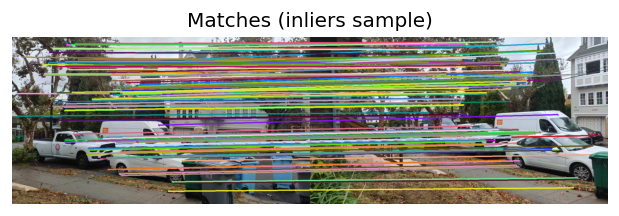

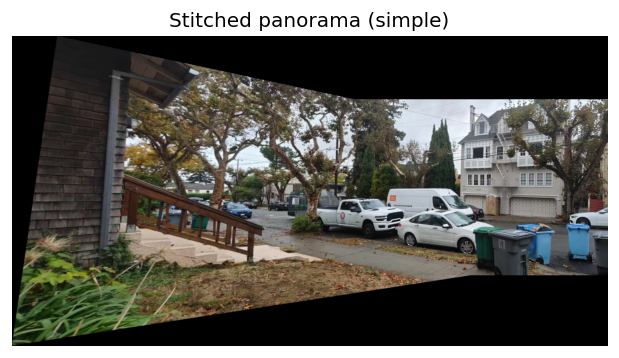

In [99]:
# 7) Demo: try loading two images and run the full pipeline (RANSAC + stitch_images)
# Modify the paths below to the image pair you want to run (relative to the notebook)
p1 = './imgs/1_1.jpg'
p2 = './imgs/1_2.jpg'

print('Using images:', p1, p2)
img1 = cv2.imread(p1)
img2 = cv2.imread(p2)
if img1 is None or img2 is None:
    print('Example images not found. Please change the paths in this cell and re-run.')
else:
    # 可选缩放以加快演示（根据图片大小调整）
    img1 = cv2.resize(img1, (0,0), fx=0.5, fy=0.5)
    img2 = cv2.resize(img2, (0,0), fx=0.5, fy=0.5)
    g1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    g2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    # Harris + ANMS + descriptors + match
    kps1, _ = harris_corners(g1, thresh_rel=0.01)
    kps2, _ = harris_corners(g2, thresh_rel=0.01)
    kps1_anms = anms(kps1, num_keep=800)
    kps2_anms = anms(kps2, num_keep=800)
    desc1, kps1_good = extract_descriptors(g1, kps1_anms, win=40, out_sz=8)
    desc2, kps2_good = extract_descriptors(g2, kps2_anms, win=40, out_sz=8)
    print('keypoints:', len(kps1_good), len(kps2_good))
    matches = match_descriptors(desc1, desc2, ratio=0.7)
    print('raw matches:', len(matches))
    # form point arrays for RANSAC in the same order as matches
    pts1 = np.array([[kps1_good[i][0], kps1_good[i][1]] for (i,_,_) in matches], dtype=np.float32)
    pts2 = np.array([[kps2_good[j][0], kps2_good[j][1]] for (_,j,_) in matches], dtype=np.float32)
    if pts1.shape[0] >= 4:
        # We want H that maps points in img2 -> img1, so use pts2->pts1
        H, inliers = ransac_homography(pts2, pts1, iters=2000, tol=4.0)
        print('RANSAC inliers:', 0 if inliers is None else len(inliers))
        if H is not None:
            # filter matches to only show inliers for clearer visualization
            if inliers is not None and len(inliers) > 0:
                inlier_matches = [matches[i] for i in inliers]
            else:
                inlier_matches = matches
            imshow_rgb(draw_matches(img1, img2, kps1_good, kps2_good, inlier_matches, max_show=200), title='Matches (inliers sample)')
            pano = stitch_images(img1, img2, H)
            imshow_rgb(pano, title='Stitched panorama (simple)')
        else:
            print('Failed to estimate homography')
    else:
        print('Not enough matches to run RANSAC (need >=4 pairs)')

In [100]:
# Batch process and save results to code/results (assemble pairs from ./imgs using naming convention: g_1 with g_2/g_3)
import glob
from pathlib import Path

# Save to a 'results' folder under the current code directory
out_dir = os.path.join(os.getcwd(), 'results')
os.makedirs(out_dir, exist_ok=True)

# Read only from ./imgs, expect filenames group_index.ext (e.g. 1_1.jpg)
img_dir = os.path.join('.', 'imgs')
if not os.path.isdir(img_dir):
    print('Directory ./imgs does not exist or contains no images. Please place images into ./imgs named group_index.ext (e.g., 1_1.jpg).')
    images = []
else:
    images = []
    for ext in ('*.jpg','*.jpeg','*.png','*.tif'):
        images += glob.glob(os.path.join(img_dir, ext))
    images = sorted(images)

print('Found images in imgs:', len(images))
# parse groups
groups = {}
for p in images:
    name = os.path.splitext(os.path.basename(p))[0]
    parts = name.split('_')
    if len(parts) != 2:
        continue
    g, idx = parts[0], parts[1]
    if not g.isdigit() or not idx.isdigit():
        continue
    if g not in groups: groups[g] = {}
    groups[g][idx] = p

# construct pairs: for each group, use 1 (center) with 2 or 3 (sides)
pairs = []
for g, items in sorted(groups.items(), key=lambda x:int(x[0])):
    if '1' not in items:
        continue
    center = items['1']
    for side_idx in ('2','3'):
        if side_idx in items:
            pairs.append((g, center, items[side_idx], side_idx))

if len(pairs) == 0:
    print('No pairs found using the naming convention. Please check that filenames in ./imgs are x_y.ext (e.g., 1_1.jpg, 1_2.jpg).')

def save_img(path, img):
    try:
        cv2.imwrite(path, img)
    except Exception as e:
        print('Save failed', path, e)

# Process each pair and save outputs for visualization
for idx, (g, p_center, p_side, side_idx) in enumerate(pairs):
    print(f'Processing group {g} pair (center vs {side_idx}):', p_center, p_side)
    I1 = cv2.imread(p_center)
    I2 = cv2.imread(p_side)
    if I1 is None or I2 is None:
        print('Cannot read image, skipping')
        continue
    scale = 0.5
    I1s = cv2.resize(I1, (0,0), fx=scale, fy=scale)
    I2s = cv2.resize(I2, (0,0), fx=scale, fy=scale)
    g1 = cv2.cvtColor(I1s, cv2.COLOR_BGR2GRAY)
    g2 = cv2.cvtColor(I2s, cv2.COLOR_BGR2GRAY)
    # Harris raw and ANMS
    kps1, h1 = harris_corners(g1, thresh_rel=0.01)
    kps2, h2 = harris_corners(g2, thresh_rel=0.01)
    kps1_anms = anms(kps1, num_keep=500)
    kps2_anms = anms(kps2, num_keep=500)
    # save Harris keypoint overlays
    vis_h1 = draw_keypoints(I1s, kps1, color=(0,255,0), radius=2)
    vis_h2 = draw_keypoints(I2s, kps2, color=(0,255,0), radius=2)
    save_img(os.path.join(out_dir, f'group{g}_harris_center.jpg'), vis_h1)
    save_img(os.path.join(out_dir, f'group{g}_harris_side{side_idx}.jpg'), vis_h2)
    # save ANMS results
    vis_a1 = draw_keypoints(I1s, kps1_anms, color=(255,0,0), radius=3)
    vis_a2 = draw_keypoints(I2s, kps2_anms, color=(255,0,0), radius=3)
    save_img(os.path.join(out_dir, f'group{g}_anms_center.jpg'), vis_a1)
    save_img(os.path.join(out_dir, f'group{g}_anms_side{side_idx}.jpg'), vis_a2)
    # descriptors and example patches: extract and save several patch thumbnails
    desc1, kps1_good = extract_descriptors(g1, kps1_anms, win=40, out_sz=8)
    desc2, kps2_good = extract_descriptors(g2, kps2_anms, win=40, out_sz=8)
    def patches_image(img_gray, kps, win=40, n=12):
        patches = []
        half = win//2
        for (x,y,_) in kps[:n]:
            x0 = int(round(x))-half; y0 = int(round(y))-half
            x1 = x0+win; y1 = y0+win
            if x0<0 or y0<0 or x1>img_gray.shape[1] or y1>img_gray.shape[0]:
                continue
            p = img_gray[y0:y1, x0:x1].astype(np.float32)
            p = cv2.GaussianBlur(p, (5,5), 1.0)
            p = cv2.resize(p, (32,32), interpolation=cv2.INTER_AREA)
            patches.append(p)
        if len(patches)==0: return None
        cols = min(4, len(patches))
        rows = int(np.ceil(len(patches)/cols))
        canvas = np.zeros((rows*32, cols*32), dtype=np.uint8)
        for i,p in enumerate(patches):
            r = i//cols; c = i%cols
            canvas[r*32:(r+1)*32, c*32:(c+1)*32] = cv2.normalize(p, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        return canvas
    patch_img1 = patches_image(g1, kps1_anms, win=40, n=12)
    patch_img2 = patches_image(g2, kps2_anms, win=40, n=12)
    if patch_img1 is not None: save_img(os.path.join(out_dir, f'group{g}_patches_center.jpg'), cv2.cvtColor(patch_img1, cv2.COLOR_GRAY2BGR))
    if patch_img2 is not None: save_img(os.path.join(out_dir, f'group{g}_patches_side{side_idx}.jpg'), cv2.cvtColor(patch_img2, cv2.COLOR_GRAY2BGR))
    # match and save match visualization
    matches = match_descriptors(desc1, desc2, ratio=0.7)
    vis_matches = draw_matches(I1s, I2s, kps1_good, kps2_good, matches, max_show=200, line_thickness=3)
    save_img(os.path.join(out_dir, f'group{g}_matches_center_vs_side{side_idx}.jpg'), vis_matches)
    # RANSAC + save panorama (if successful)
    pts1 = np.array([[kps1_good[i][0], kps1_good[i][1]] for (i,_,_) in matches], dtype=np.float32)
    pts2 = np.array([[kps2_good[j][0], kps2_good[j][1]] for (_,j,_) in matches], dtype=np.float32)
    if pts1.shape[0] >= 4:
        H, inliers = ransac_homography(pts2, pts1, iters=2000, tol=4.0)
        if H is not None:
            # save inlier match visualization
            if inliers is not None and len(inliers)>0:
                inlier_matches = [matches[i] for i in inliers]
            else:
                inlier_matches = matches
            vis_inliers = draw_matches(I1s, I2s, kps1_good, kps2_good, inlier_matches, max_show=200, line_thickness=3)
            save_img(os.path.join(out_dir, f'group{g}_inliers_center_vs_side{side_idx}.jpg'), vis_inliers)
            pano = stitch_images(I1s, I2s, H)
            save_img(os.path.join(out_dir, f'group{g}_panorama_center_vs_side{side_idx}.jpg'), pano)
            print('Saved results for group', g, 'pair with side', side_idx)
        else:
            print('RANSAC did not find a homography, skipping stitching for group', g, 'side', side_idx)
    else:
        print('Not enough matches to run RANSAC for group', g, 'side', side_idx)

print('All done. Results saved to', out_dir)

Found images in imgs: 13
Processing group 1 pair (center vs 2): .\imgs\1_1.jpg .\imgs\1_2.jpg
Saved results for group 1 pair with side 2
Processing group 1 pair (center vs 3): .\imgs\1_1.jpg .\imgs\1_3.jpg
Saved results for group 1 pair with side 2
Processing group 1 pair (center vs 3): .\imgs\1_1.jpg .\imgs\1_3.jpg
Saved results for group 1 pair with side 3
Processing group 2 pair (center vs 2): .\imgs\2_1.jpg .\imgs\2_2.jpg
Saved results for group 1 pair with side 3
Processing group 2 pair (center vs 2): .\imgs\2_1.jpg .\imgs\2_2.jpg
Saved results for group 2 pair with side 2
Processing group 2 pair (center vs 3): .\imgs\2_1.jpg .\imgs\2_3.jpg
Saved results for group 2 pair with side 2
Processing group 2 pair (center vs 3): .\imgs\2_1.jpg .\imgs\2_3.jpg
Saved results for group 2 pair with side 3
Processing group 3 pair (center vs 2): .\imgs\3_1.jpg .\imgs\3_2.jpg
Saved results for group 2 pair with side 3
Processing group 3 pair (center vs 2): .\imgs\3_1.jpg .\imgs\3_2.jpg
Saved resu